In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as la
from scipy.spatial import distance
from scipy import stats
import pandas as pd

In [2]:
images = np.genfromtxt("/Users/ozlemserifogullari/Documents/ENGR421/HW7/hw07_data_set_images.csv", delimiter = ",", skip_header = 0)
classes = np.genfromtxt("/Users/ozlemserifogullari/Documents/ENGR421/HW7/hw07_data_set_labels.csv", delimiter = ",", skip_header = 0, dtype=int)

train_indices = np.arange(0,2000)
test_indices = np.arange(2000,4000)
x_train = images[train_indices,:]
y_train = classes[train_indices]
x_test = images[test_indices,:]
y_test = classes[test_indices]

N = x_train.shape[0]
D = x_train.shape[1]
K = int(max(y_train))
N_test = x_test.shape[0]



2000 784 10 2000
3


In [3]:
def calculate_total_wcs_mat(x, y, means):
    result = np.zeros((D,D))
    wcs_mat = [(np.dot(np.transpose(x[y == (c + 1)] - means[c]), (x[y == (c + 1)] - means[c]))) for c in range(K)]
    for i in range(D):
        for j in range(D):
            sum = 0
            for k in range(K):
                sum += wcs_mat[k][i][j]
            result[i][j] = sum
            
    return result

def calculate_bcs_mat(x, y, means):
    result = np.zeros((D,D))
    overall_mean = np.mean(x, axis = 0)
    Ni = [len(x[y == c+1]) for c in range(K)]
    for k in range(K):
        m = (means[k] - overall_mean).reshape(D,1)
        result += Ni[k] * np.dot(m, np.transpose(m))     
    return result

In [4]:
class_means = np.array([np.mean(x_train[y_train == i + 1,] , axis=0) for i in range(K)])
SW = calculate_total_wcs_mat(x_train, y_train, class_means)
SB = calculate_bcs_mat(x_train, y_train, class_means)
print(SW[0:4, 0:4])
print(SB[0:4, 0:4])

[[  195.0531401    138.98550725   138.24154589   273.64251208
    184.90821256]
 [  138.98550725   146.68407152   137.97108222   212.80522823
    144.25612894]
 [  138.24154589   137.97108222   237.79940915   222.04558827
    157.47422967]
 [  273.64251208   212.80522823   222.04558827 10381.73114607
   8779.022599  ]
 [  184.90821256   144.25612894   157.47422967  8779.022599
  21507.10414962]]
[[  0.8488599    0.86049275   1.26145411   4.64248792   7.89978744]
 [  0.86049275   1.07392848   2.24791778   8.49977177  10.72787106]
 [  1.26145411   2.24791778   6.68009085  25.25691173  26.33777033]
 [  4.64248792   8.49977177  25.25691173  97.25635393  94.117401  ]
 [  7.89978744  10.72787106  26.33777033  94.117401   144.92785038]]


In [5]:
SW_inverse = np.linalg.inv(SW)
values, vectors = la.eig(np.dot(SW_inverse, SB))
values = np.real(values)
vectors = np.real(vectors)

print(values[0:9])

lnine_eigv = values[0:9]
eigvectors = vectors[:, 0:9]
#print(eigvectors)

[26.03085646 11.57909822  7.86259994  5.12082313  3.60002676  3.22503144
  2.71288241  1.3688596   1.13340931]


In [6]:
def calculate_z(x, mean, W_transpose):
    return np.dot(x - mean, W_transpose)

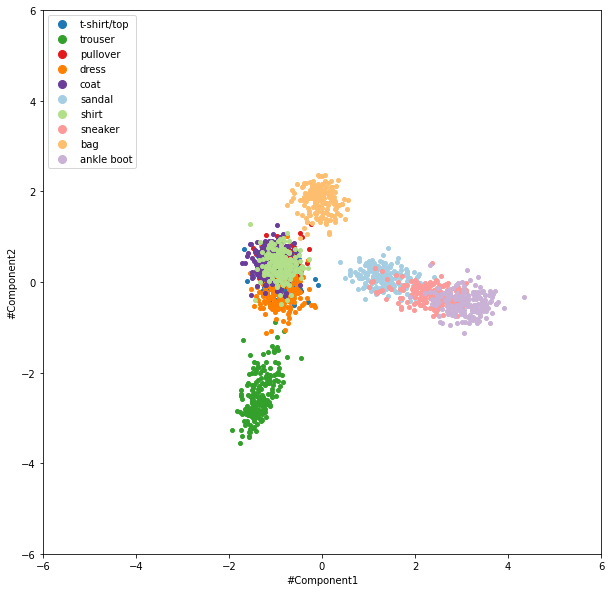

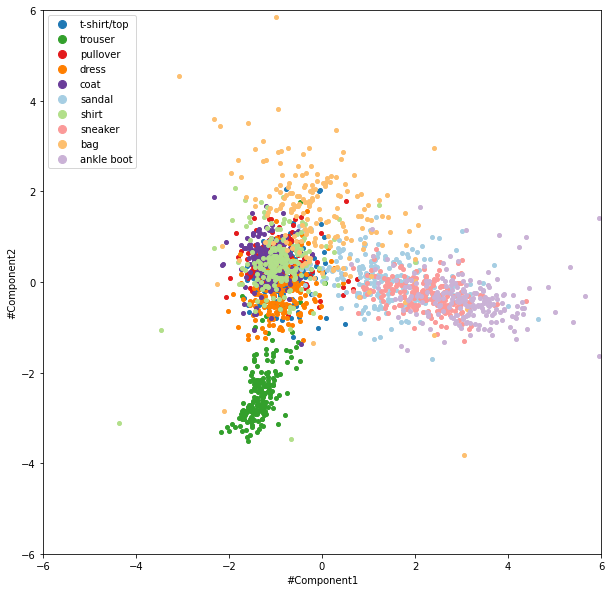

In [7]:
# calculate two-dimensional projections
z_train = calculate_z(x_train, np.mean(x_train, axis = 0),vectors[:,[0, 1]])
z_test = calculate_z(x_test, np.mean(x_train, axis = 0),vectors[:,[0, 1]])
# plot two-dimensional projections
plt.figure(figsize = (10, 10))
point_colors = np.array(["#1f78b4", "#33a02c", "#e31a1c", "#ff7f00", "#6a3d9a", "#a6cee3", "#b2df8a", "#fb9a99", "#fdbf6f", "#cab2d6"])
for c in range(K):
    plt.plot(z_train[y_train == c + 1, 0], z_train[y_train == c + 1, 1], marker = "o", markersize = 4, linestyle = "none", color = point_colors[c])
plt.legend(["t-shirt/top", "trouser", "pullover", "dress", "coat", "sandal", "shirt", "sneaker", "bag","ankle boot" ],
           loc = "upper left", markerscale = 2)
plt.xlabel("#Component1")
plt.ylabel("#Component2")
plt.ylim(-6,6) # set the y limits
plt.xlim(-6,6) # set the x limits
plt.show()

plt.figure(figsize = (10, 10))
point_colors = np.array(["#1f78b4", "#33a02c", "#e31a1c", "#ff7f00", "#6a3d9a", "#a6cee3", "#b2df8a", "#fb9a99", "#fdbf6f", "#cab2d6"])
for c in range(K):
    plt.plot(z_test[y_test == c + 1, 0], z_test[y_test == c + 1, 1], marker = "o", markersize = 4, linestyle = "none", color = point_colors[c])
plt.legend(["t-shirt/top", "trouser", "pullover", "dress", "coat", "sandal", "shirt", "sneaker", "bag","ankle boot" ],
           loc = "upper left", markerscale = 2)
plt.xlabel("#Component1")
plt.ylabel("#Component2")
plt.ylim(-6,6) #set the y limits
plt.xlim(-6,6) #set the x limits
plt.show()

In [8]:
# Learn a 𝑘-nearest neighbor classifier 
def k_nn(y, z, z_train, k):
    result = []
    for i in range(z.shape[0]):
        current = z[i,:]
        distances = np.zeros(z_train.shape[0])
        for j in range(z_train.shape[0]):
            distances[j] = distance.euclidean(current, z_train[j, :])
        nearests = np.argsort(distances)[:k]
        possible_y = []
        for i in nearests:
            possible_y.append(y[i])
        y_hat = stats.mode(possible_y)[0]
        result.append(y_hat)
    return result
            

In [9]:
# calculate nine-dimensional projections
z_train = calculate_z(x_train, np.mean(x_train, axis = 0),vectors[:,0:9])
z_test = calculate_z(x_test, np.mean(x_train, axis = 0),vectors[:,0:9])

# set k = 11
y_pred_train = k_nn(y_train, z_train, z_train, 11)
y_pred_test = k_nn(y_train, z_test, z_train, 11)

In [10]:
# confusion matrix
def print_confusion_matrix(y_truth, y_pred, no, colname):
    confusion_matrix = pd.crosstab(np.reshape(y_pred, no), y_truth,
                               rownames = ["y_hat"], colnames = [colname])
    print(confusion_matrix)

In [11]:
print_confusion_matrix(y_train, y_pred_train, N, "y_train")
print_confusion_matrix(y_test, y_pred_test, N_test, "y_test")

y_train   1    2    3    4    5    6    7    8    9    10
y_hat                                                    
1        203    0    1    1    0    0   15    0    0    0
2          0  192    0    1    0    0    0    0    0    0
3          0    0  198    0    3    0   11    0    0    0
4          2    2    1  202    3    0    4    0    0    0
5          0    0    8    1  201    0    9    0    0    0
6          0    0    0    0    0  175    0    3    0    0
7          9    0    2    6   11    0  168    0    1    0
8          0    0    0    0    0    3    0  196    0    1
9          0    0    0    0    0    0    0    0  183    0
10         0    0    0    0    0    0    0    0    0  184
y_test   1    2    3    4    5    6   7    8    9    10
y_hat                                                  
1       142    1   21    7    1    2  42    0    6    2
2         0  183    1    4    2    0   1    0    0    0
3         3    1  115    1   25    1  26    0    5    0
4        17    3    4  1